### Finding Similar Quora Questions with BOW, TFIDF and Xgboost

By Susan Li, from https://towardsdatascience.com/finding-similar-quora-questions-with-bow-tfidf-and-random-forest-c54ad88d1370.

The author developed a machine learning and NLP system to classify whether question pairs are duplicates or not and started from a model that is BOW or TF-IDF with Xgboost.

I am reprocessing the author's codes to understanding its solution Quora problem.

In [2]:
# packages

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preprocessing

In [3]:
df = pd.read_csv('datasets/quora_train.csv')
df

id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
404285  404285  433578  379845   
404286  404286   18840  155606   
404287  404287  537928  537929   
404288  404288  537930  537931   
404289  404289  537932  537933   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287                                  What is one coin?   
404288  What is the approx annual cost of living while...   
404289              What is like to have sex with cousin?   

                                                question2  is_duplicate  
0       What is the step by step guide to invest in sh...             0  
1       What would happen if the Indian government sto...             0  
2       How can Internet speed be increased by hacking...             0  
3       Find the remainder when [math]23^{24}[/math] i...             0  
4                 Which fish would survive in salt water?             0  
...                                                   ...           ...  
404285  How many keywords are there in PERL Programmin...             0  
404286         Is it true that there is life after death?             1  
404287                                  What's this coin?             0  
404288  I am having little hairfall problem but I want...             0  
404289      What is it like to have sex with your cousin?             0  

[404290 rows x 6 columns]

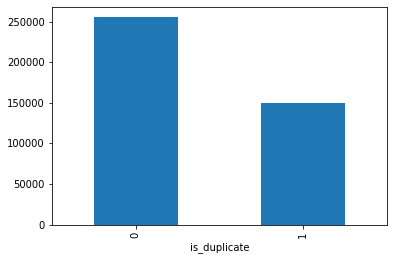

In [4]:
df.dropna(axis=0, inplace=True)
df.groupby("is_duplicate")['id'].count().plot.bar()

In [4]:
# Before cleaning the text, we preview a few question pairs to determine how to clean them.

df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
df

question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287                                  What is one coin?   
404288  What is the approx annual cost of living while...   
404289              What is like to have sex with cousin?   

                                                question2  is_duplicate  
0       What is the step by step guide to invest in sh...             0  
1       What would happen if the Indian government sto...             0  
2       How can Internet speed be increased by hacking...             0  
3       Find the remainder when [math]23^{24}[/math] i...             0  
4                 Which fish would survive in salt water?             0  
...                                                   ...           ...  
404285  How many keywords are there in PERL Programmin...             0  
404286         Is it true that there is life after death?             1  
404287                                  What's this coin?             0  
404288  I am having little hairfall problem but I want...             0  
404289      What is it like to have sex with your cousin?             0  

[404287 rows x 3 columns]

In [17]:
for i in range(0, 10):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

#### Text Cleaning

The author decided to clean the text as follows:

* Not to remove stop words, because words like “what”, “which” and “how” may have strong signals.
* Not to stem words.
* Remove punctuation.
* Correct typos.
* Change abbreviations to its original terms.
* Remove comma between numbers.
* Change special chars to words. And so on.

In [5]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

In [6]:
def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' ' + s + ' '
    
    if pd.isnull(text):
        return ''
    
    # stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text == '':
        return ''
    
    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    # all numbers should separate from words, this is too aggressive
    
    # def pad_number(pattern):
          # matched_string = pattern.group(0)
          # return pad_str(matched_string)
    # text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    # def pad_pattern(pattern):
          # matched_string = pattern.group(0)
          # return pad_str(matched_string)
    # text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from: https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
    
    # Return a list of words
    return text

In [7]:
# Applying the previous function in df
df['question1'] = df['question1'].apply(clean)

In [8]:
# Applying the previous function in df
df['question2'] = df['question2'].apply(clean)

In [22]:
# after cleaning text, preview those question pairs again
for i in range(0, 10):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

**Obs.**: The Panda's _concat_ function was used to concatenate two text objects features from question1 and question2 into one. The _scipy.sparse.hstackis_ was used to stack sparse matrices horizontally (column wise).

### Bag-Of-Words + Xgboost Model

The following strategy (CountVectorizer) is called the **Bag of Words**. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document. It tokenizes the documents and counts the occurrences of token and return them as a sparse matrix.

Obs.: Tokens are individual terms, as words. A token is a caracteres sequence between two spaces, or between a space and punctuation marks.

In [23]:
# Xgboost parameters used

# max_depth=50
# n_estimators=80
# objective='binary:logistic'
# eta=0.3

In [34]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat((df['question1'], df['question2'])).unique())
trainq1_trans = count_vect.transform(df['question1'].values)
trainq2_trans = count_vect.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans, trainq2_trans))
y = labels
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, \
                              gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, \
                              subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

In [35]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

training score: 0.82794751142685
validation score: 0.7587822398640196
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     84267
           1       0.78      0.60      0.67     49148

    accuracy                           0.79    133415
   macro avg       0.78      0.75      0.76    133415
weighted avg       0.79      0.79      0.78    133415



### Word level TF-IDF + Xgboost

The **tf–idf** is the product of two statistics, term frequency and inverse document frequency, it is one of the most popular term-weighting schemes today.

The author apply tf-idf normalization to a sparse matrix of occurrence counts, from word level, n-gram level and character level.

In [39]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(pd.concat((df['question1'], df['question2'])).unique())
trainq1_trans = tfidf_vect.transform(df['question1'].values)
trainq2_trans = tfidf_vect.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans, trainq2_trans))
y = labels
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, \
                              gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, \
                              subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

In [40]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('word level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('word level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

word level tf-idf training score: 0.8881877789035716
word level tf-idf validation score: 0.7617201122126664
              precision    recall  f1-score   support

           0       0.80      0.90      0.84     84267
           1       0.78      0.60      0.68     49148

    accuracy                           0.79    133415
   macro avg       0.79      0.75      0.76    133415
weighted avg       0.79      0.79      0.78    133415



OBS.: A subtle point about feature engineering is that it requires knowing feature statistics that we most likely do not know in practice. In order to compute the tf-idf representation, we have to compute the inverse document frequencies based on the training data and use these statistics to scale both the training and test data. In scikit-learn, fitting the feature transformer on the training data amounts to collecting the relevant statistics. The fitted transformer can then be applied to the test data.

### N-gram Level TF-IDF + Xgboost

In [7]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(pd.concat((df['question1'], df['question2'])).unique())
trainq1_trans = tfidf_vect_ngram.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram.transform(df['question2'].values)

labels = df['is_duplicate'].values

X = scipy.sparse.hstack((trainq1_trans, trainq2_trans))
y = labels
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, \
                              gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, \
                              subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

In [43]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('n-gram level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('n-gram level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

n-gram level tf-idf training score: 0.7436523182849621
n-gram level tf-idf validation score: 0.6789716216415488
              precision    recall  f1-score   support

           0       0.73      0.92      0.81     84267
           1       0.75      0.43      0.54     49148

    accuracy                           0.74    133415
   macro avg       0.74      0.67      0.68    133415
weighted avg       0.74      0.74      0.71    133415



### Character Level TF-IDF + Xgboost

In [ ]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), \
                                         max_features=5000)
tfidf_vect_ngram_chars.fit(pd.concat((df['question1'], df['question2'])).unique())

In [10]:
trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)

In [11]:
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)

In [12]:
labels = df['is_duplicate'].values

In [ ]:
X = scipy.sparse.hstack((trainq1_trans, trainq2_trans))

In [ ]:
y = labels

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, \
                              gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, \
                              subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

In [ ]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('character level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('character level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

### Conclusion

Our highest validation score is 0.80, not bad at all for starters! **OBS.: The 'Character Level TF-IDF + Xgboost' example did not run effectively because the kernel dies when execute the command line "X = scipy.sparse.hstack((trainq1_trans, trainq2_trans))".**

So far our best Xgboost model is character level TF-IDF + Xgboost, the recall of duplicate questions, that is, the proportion of duplicate questions that our model is able to detect over the total amount of duplicate questions is 0.67. And this is crucial for the problem at hand, we want to detect and eliminate as many duplicate questions as possible.